# Elevation indices

Here we assume that flow directions are known. We read the flow direction raster data, including meta-data, using [rasterio](https://rasterio.readthedocs.io/en/latest/) and parse it to a pyflwdir `FlwDirRaster` object, see earlier examples for more background.

In [1]:
# import pyflwdir, some dependencies and convenience methods
import geopandas as gpd
import numpy as np
import rasterio
from utils import quickplot, plt  # data specific quick plot method
import pyflwdir

# read and parse flow direciton data
with rasterio.open("rhine_d8.tif", "r") as src:
    flwdir = src.read(1)
    crs = src.crs
    extent = np.array(src.bounds)[[0, 2, 1, 3]]
    flw = pyflwdir.from_array(
        flwdir,
        ftype="d8",
        transform=src.transform,
        latlon=crs.is_geographic,
        cache=True,
    )
# read elevation data
with rasterio.open("rhine_elv0.tif", "r") as src:
    elevtn = src.read(1)

## height above nearest drain (HAND)

The [hand()](reference.rst#pyflwdir.FlwdirRaster.hand) method uses drainage-normalized topography and flowpaths to delineate the relative vertical distances (drop) to the nearest river (drain) as a proxy for the potential extent of flooding ([Nobre et al. 2016](https://doi.org/10.1002/hyp.10581)). The pyflwdir implementation requires stream mask `drain` and elevation raster `elevtn`. The stream mask is typically determined based on a threshold on [upstream_area()](reference.rst#pyflwdir.FlwdirRaster.upstream_area) or [stream_order()](reference.rst#pyflwdir.FlwdirRaster.stream_order), but can also be set from rasterizing a vector stream file.

In [2]:
# first we derive the upstream area map
uparea = flw.upstream_area("km2")

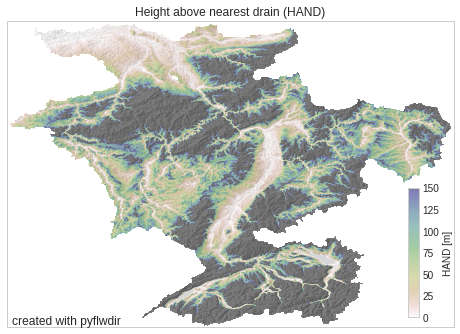

In [3]:
# HAND based on streams defined by a minimal upstream area of 1000 km2
hand = flw.hand(drain=uparea > 1000, elevtn=elevtn)
# plot
ax = quickplot(title="Height above nearest drain (HAND)")
im = ax.imshow(
    np.ma.masked_equal(hand, -9999),
    extent=extent,
    cmap="gist_earth_r",
    alpha=0.5,
    vmin=0,
    vmax=150,
)
fig = plt.gcf()
cax = fig.add_axes([0.82, 0.37, 0.02, 0.12])
fig.colorbar(im, cax=cax, orientation="vertical")
cax.set_ylabel("HAND [m]")
plt.savefig("hand.png")

## Floodplains

The [floodplains()](reference.rst#pyflwdir.FlwdirRaster.floodplains) method delineates geomorphic floodplain boundaries based on a power-law relation between upstream area and a maximum HAND contour as developed by [Nardi et al (2019)](http://www.doi.org/10.1038/sdata.2018.309). Here, streams are defined based on a minimum upstream area threshold `upa_min` and floodplains on the scaling parameter `b` of the power-law relationship.

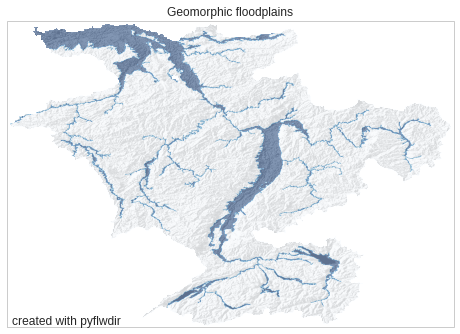

In [4]:
floodplains = flw.floodplains(elevtn=elevtn, uparea=uparea, upa_min=1000)
# plot
floodmap = (floodplains, -1, dict(cmap="Blues", alpha=0.5, vmin=0))
ax = quickplot(
    raster=floodmap, title="Geomorphic floodplains", filename="flw_floodplain"
)